# 01 — Supervised Learning and a First Neural Network
## Training, Validation, and Generalization

In this notebook we will:

- Formalize **supervised learning**.
- Build a simple **classification** example.
- Introduce the idea of a **training / validation split**.
- Train two models:
  - a **linear classifier**,
  - a small **neural network (multi-layer perceptron)**.
- Compare their performance and decision boundaries.
- See a first glimpse of **overfitting** and **generalization**.

We will keep everything low-dimensional and visual.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report

rng = np.random.default_rng(1)

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

## 1. What is supervised learning?

We observe **pairs of data**:

$(x_i, y_i) \quad i = 1, \dots, N.$

- $x_i$: input / features  
- $y_i$: target / label

A **model** is a function:

$\hat{y} = f_\theta(x),$

with parameters $\theta$.

We choose a **loss function** $\mathcal{L}(y, \hat{y})$,
and we fit the model by minimizing the average loss:

$\theta^* = \arg\min_\theta \frac{1}{N} \sum_i \mathcal{L}(y_i, f_\theta(x_i)).$

Supervised learning comes in two main flavors:

- **Regression**: y is continuous (e.g. energy, flux, parameter value).
- **Classification**: y is a discrete class (e.g. type of event, model A vs B).

In this notebook we will focus on a **binary classification** task (two classes) to make things easy to visualize.


X shape: (1000, 2)
y shape: (1000,)


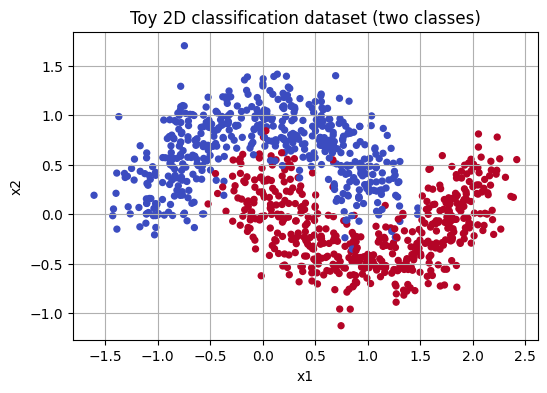

In [2]:
from sklearn.datasets import make_moons

# N samples from a 2D "moons" dataset (two interleaving half circles)
N = 1000
X, y = make_moons(n_samples=N, noise=0.2, random_state=1)

print("X shape:", X.shape)
print("y shape:", y.shape)
np.unique(y, return_counts=True)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=18)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Toy 2D classification dataset (two classes)")
plt.show()

## 2. Training vs validation: why we split the data

Our goal is not only to fit the data we have, but to **generalize** to new data we haven't seen.

If we train and evaluate on exactly the same points, we might fool ourselves:
- a very flexible model can memorize the training data,
- but perform poorly on new data.

To detect this, we split the dataset into:

- a **training set**: used to fit the model parameters,
- a **validation set** (or test set): used only to evaluate performance.

If the model performs well on training data but poorly on validation data, it is **overfitting**.

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

print("Training size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])


Training size: 700
Validation size: 300


## 3. Baseline model: logistic regression (linear classifier)

We start with a simple **linear classifier**:

$f_\theta(x) = \sigma(w^T x + b),$

where $\sigma$ is the logistic (sigmoid) function and $(w, b)$ are parameters.

This model can only learn **linear decision boundaries** in the input space.
On our 2D dataset, that means it can only separate the classes with (roughly) a straight line.

We will use scikit-learn's `LogisticRegression` to fit this model.


In [4]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
y_val_pred   = log_reg.predict(X_val)

acc_train = accuracy_score(y_train, y_train_pred)
acc_val   = accuracy_score(y_val, y_val_pred)

print(f"Logistic regression accuracy (train): {acc_train:.3f}")
print(f"Logistic regression accuracy (val)  : {acc_val:.3f}")

Logistic regression accuracy (train): 0.877
Logistic regression accuracy (val)  : 0.843


In [5]:
def plot_decision_boundary(model, X, y, title="Decision boundary"):
    #Create a grid over feature space
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300),
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    #Model predictions on the grid
    zz = model.predict(grid)
    zz = zz.reshape(xx.shape)
    
    #Plot contour + data
    plt.contourf(xx, yy, zz, alpha=0.25, cmap="coolwarm")
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=18, edgecolor="k", linewidth=0.3)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.show()

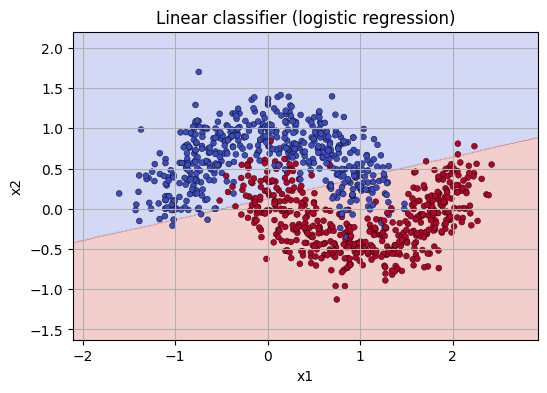

In [6]:
plot_decision_boundary(log_reg, X, y, title="Linear classifier (logistic regression)")

# 4. Evaluation metrics

## Confusion Matrix

For binary classification, each prediction falls into one of four categories:

- **True Positive (TP)**: predicted 1, true label is 1
- **True Negative (TN)**: predicted 0, true label is 0
- **False Positive (FP)**: predicted 1, true label is 0
- **False Negative (FN)**: predicted 0, true label is 1

A **confusion matrix** summarizes these counts:


\begin{pmatrix}
TN & FP \\
FN & TP
\end{pmatrix}


This is often the most informative evaluation tool because it shows **what kind** of mistakes the model makes.


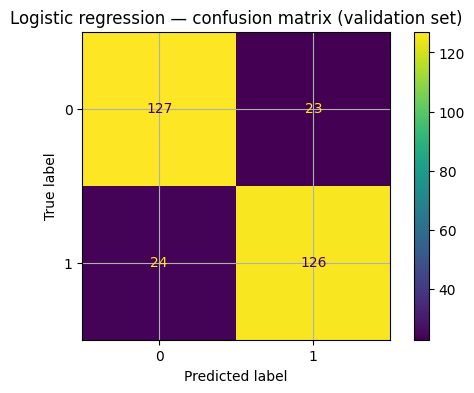

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Logistic regression — confusion matrix (validation set)")
plt.show()

## ROC curve and AUC

A ROC curve shows how the classifier performs over *all* possible thresholds.

It plots:

- **True Positive Rate (TPR)** = Recall
\[
TPR = \frac{TP}{TP + FN}
\]

against:

- **False Positive Rate (FPR)**
\[
FPR = \frac{FP}{FP + TN}
\]

Each threshold corresponds to one point on the ROC curve.

---

### AUC: Area Under the Curve

The **AUC score** is:

\[
AUC = \int_0^1 TPR(FPR)\, d(FPR)
\]

Interpretation:
- AUC = 0.5 → random classifier
- AUC = 1.0 → perfect classifier
- Higher AUC means better separability between classes

Important:
- AUC uses **probabilities**, not hard labels
- AUC is robust to imbalanced classes (more than accuracy)


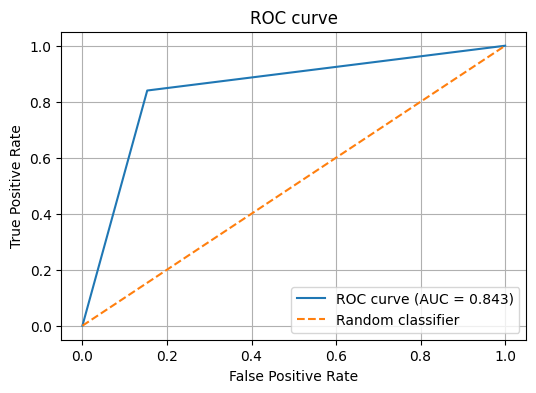

AUC: 0.8433333333333333


In [10]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)
fpr, tpr, roc_thresholds = roc_curve(y_val, y_val_pred)
auc = roc_auc_score(y_val, y_val_pred)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], "--", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()

print("AUC:", auc)
